###Dataset info
This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers. \

Dataset contains 1067371 rows and 8 columns.

###Overview of data
- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
- UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal. The name of the country where a customer resides.

##EDA
1. Первым этапом загружаем датасет.  \

- **data_1** -  данные за 2009 и 2010 года
- **data_2** - данные за 2010 и 2011 года





In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=9a8f741c06a3945640d9222182f3726eb3d939bae9be4e1e53f05ef2b48050e1
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import wget

url = 'https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip'
filename = wget.download(url) #returns file name

with zipfile.ZipFile(filename, 'r') as zip_ref: #read mode
    zip_ref.extractall('./')

Data_1 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010') #use data from list 1(Year 2009-2010)
Data_2 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011') #use data from list 2(Year 2010-2011)

In [ ]:
data_1 = Data_1
data_2 = Data_2
data_size = len(data_1)+len(data_2)

2. Обрабатываем значения в датасете.
    - находим пропущенные значения

In [ ]:
null_1 = data_1.isnull().sum() #series: the first coloumn - names of coloumns from data_1,
                               #the second coloumn - the quantity of empty cells for every attribute
perc = null_1 / len(data_1)
null_data_1 = pd.concat([null_1, perc], axis=1, keys=['num_null_values', 'percentage_null_vaLues'])
display(null_data_1)

null_2 = data_2.isnull().sum() #series: the first coloumn - names of coloumns from data_2,
                               #the second coloumn - the quantity of empty cells for every attribute
perc = null_2 / len(data_2)
null_data_2 = pd.concat([null_2, perc], axis=1, keys=['num_null_values', 'percentage_null_vaLues'])
display(null_data_2)


print("Percent of emty cells in Customer ID: ", (null_data_1.iat[6, 0] + null_data_2.iat[6,0])/(len(data_1)+len(data_2))*100)

,num_null_values,percentage_null_vaLues
Invoice,0,0.000000
StockCode,0,0.000000
Description,2928,0.005572
Quantity,0,0.000000
InvoiceDate,0,0.000000
Price,0,0.000000
Customer ID,107927,0.205395
Country,0,0.000000


,num_null_values,percentage_null_vaLues
Invoice,0,0.000000
StockCode,0,0.000000
Description,1454,0.002683
Quantity,0,0.000000
InvoiceDate,0,0.000000
Price,0,0.000000
Customer ID,135080,0.249266
Country,0,0.000000


Percent of emty cells in Customer ID:  22.766872999172733


Выяснили, что отсутствует около 20-24% данный Сustomer ID в обои датафреймах, что составляет примерно 22,7% от всей бд. Для задачи классификации  RFM нам вполне будет достаточно оставшихся данных, так как попытка подстановки каких-либо значение в Customer ID приведет к слиьному искажению данных, так что при построении этой модели удалим строки с пропущенными значениями Сustomer ID. Удаляем их.

In [ ]:
data_1 = data_1.dropna(subset=['Customer ID']).reset_index(drop=True)
data_2 = data_2.dropna(subset=['Customer ID']).reset_index(drop=True)

print(f'Number of rows in data_1: {len(data_1)}')
print(f'Number of rows in data_2: {len(data_2)}')

Number of rows in data_1: 417534
Number of rows in data_2: 406830


   - Выявляем аномалии.

   Из аномалий датасете есть отмененные транзакции.  Найдем их количество.

In [ ]:
data1 = data_1.copy()
data1['t'] = data_1['Invoice'].apply(lambda x: type(x)) #define dtype of the invoice (string or int)
data1['t'] = data1['t'] == int #if dtype is string, the value is 0, otherwise 1
print("Percent of cancelled transactions in 2009-2010: ", len(data1.loc[data1.t == False])/data_size*100)

data2 = data_2.copy()
data2['t'] = data_2.Invoice.apply(lambda x: type(x))
data2['t'] = data2['t'] == int
print("Percent of cancelled transactions in 2010-2011: ", len(data2.loc[data2.t == False])/data_size*100)

Percent of cancelled transactions in 2009-2010:  0.9217975755384022
Percent of cancelled transactions in 2010-2011:  0.8342928559985234


  Отмененных транзакций в сумме меньше двух процентов, поэтому удалим их, так как не известна причина отмены, из-за чего они могут помешать построению точной модели.

In [ ]:
data_1['t'] = data1['t']
data_1 = data_1.loc[data_1.t == True]#.reset_index(drop=True)#Drop cancelled transactions
data_1 = data_1.drop(columns=['t']).reset_index(drop=True)
print(f'Number of rows in data_1: {len(data_1)}')

data_2['t'] = data2['t']
data_2 = data_2.loc[data_2.t == True]
data_2 = data_2.drop(columns=['t']).reset_index(drop=True)
print(f'Number of rows in data_2: {len(data_2)}')

data_size = len(data_1) + len(data_2)
print(f'Total datasset size: {data_size}')

Number of rows in data_1: 407695
Number of rows in data_2: 397925
Total datasset size: 805620


   - Поищем аномалии в столбцах Quantity и Price

In [ ]:
#Negative quantity of products
print(f"data_1 percentage of not positive quantity: {len(data_1.loc[data_1.Quantity <= 0])/data_size*100}")
print(f'data_2 percentage of not positive quantity: {len(data_2.loc[data_2.Quantity <= 0])/data_size*100}', '\n')

#Negative price of products
print(f'data_1 percentage of negative prices: {len(data_1.loc[data_1.Price <= 0])/data_size*100}')
print(f'data_2 percentage of negative prices: {len(data_2.loc[data_2.Price <= 0])/data_size*100}')

data_1 percentage of not positive quantity: 0.0
data_2 percentage of not positive quantity: 0.0 

data_1 percentage of negative prices: 0.003847968024626995
data_2 percentage of negative prices: 0.004965120031776768


 Удалим строки с отрицательными Quantity, так как их количеество меньше одного процента.

In [ ]:
data_1 = data_1.loc[data_1.Quantity > 0].reset_index(drop=True)
data_1 = data_1.loc[data_1.Price > 0].reset_index(drop=True)
print(f'Number of rows in data_1: {len(data_1)}')

data_2 = data_2.loc[data_2.Quantity > 0].reset_index(drop=True)
data_2 = data_2.loc[data_2.Price > 0].reset_index(drop=True)
print(f'Number of rows in data_2: {len(data_2)}')

data_size = len(data_1) + len(data_2)
print(f'Total datasset size: {data_size}')

Number of rows in data_1: 407664
Number of rows in data_2: 397885
Total datasset size: 805549


 -  Удалим дубликаты

In [ ]:
data_1 = data_1.drop_duplicates()
print(f'Number of rows in data_1: {len(data_1)}')

data_2 = data_2.drop_duplicates()
print(f'Number of rows in data_2: {len(data_2)}')

data_size = len(data_1) + len(data_2)
print(f'Total datasset size: {data_size}')

Number of rows in data_1: 400916
Number of rows in data_2: 392693
Total datasset size: 793609


  - Найдем выбросы и удалим их. Чтобы понять, является ли значение выбросом, воспользуемся интерквартильным размахом:
  $$
IRL=Q_3-Q_1
  $$
  где $Q_1$ — первая квартиль — такое значение признака, меньше которого ровно 25% всех значений признаков. $Q_3$ — третья квартиль — значение, меньше которого ровно 75% всех значений признака. \
  Выбросы будут лежать вне данного интервала $[ Q_1 -1.5IQR, Q_3 + 1.5IQR ]$.

In [ ]:
def IRL(data, var):
  q_1 = data[var].quantile(.25)
  q_3 = data[var].quantile(.75)
  irl = q_3-q_1
  bottom = q_1 - 1.5*irl
  top = q_3 + 1.5*irl
  data = data.loc[data[var] <= top]
  data = data.loc[data[var] >= bottom]
  return data

data_1 = IRL(data_1, 'Quantity')
data_1 = IRL(data_1, 'Price')
data_2 = IRL(data_2, 'Quantity')
data_2 = IRL(data_2, 'Price')
data_size = len(data_1) + len(data_2)

print(f'Number of rows in data_1: {len(data_1)}')
print(f'Number of rows in data_2: {len(data_2)}')
print(f'Total datasset size: {data_size}')

Number of rows in data_1: 342273
Number of rows in data_2: 333234
Total datasset size: 675507


In [ ]:
print(f'Percent of data_1: {len(data_1)/data_size*100}')
print(f'Percent of data_2: {len(data_2)/data_size*100}')

Percent of data_1: 50.66905302239652
Percent of data_2: 49.33094697760349


**Данные готовы**


------------
---

#**Построение моделей**


###**Модель 1**

В первой модели будем прогнозировать количество товаров, которое будет продано в следующем году. Так как процент данных для каждого года составляет около 50%, можем обучать модель на 2009-2010 годах, а тестировать на 2010-2011 годах.
Начнем построение регресионной модели


In [ ]:
X_train = data_1['Price'].to_numpy()
y_train = data_1['Quantity'].to_numpy()
X_test = data_2['Price'].to_numpy()
y_test = data_2['Quantity'].to_numpy()

N = len(X_train)
x_summ = 0
y_summ = 0
for i in range(len(X_train)):
    x_summ += X_train[i]
for j in range(len(y_train)):
    y_summ += y_train[j]
mx = x_summ / N
my = y_summ / N
alpha2 = np.dot(X_train.T, X_train) / N
alpha11 = np.dot(X_train.T, y_train) / N
k = (alpha11 - mx * my) / (alpha2 - mx ** 2)
b = my - k * mx
print("y = ", k, "* x + ", b)


y =  -1.4166225350081039 * x +  10.55288589807121


Изобразим графики точек $(x_i, y_i)$ из обучаюей и тестовой выборок и полученную линейную функцию

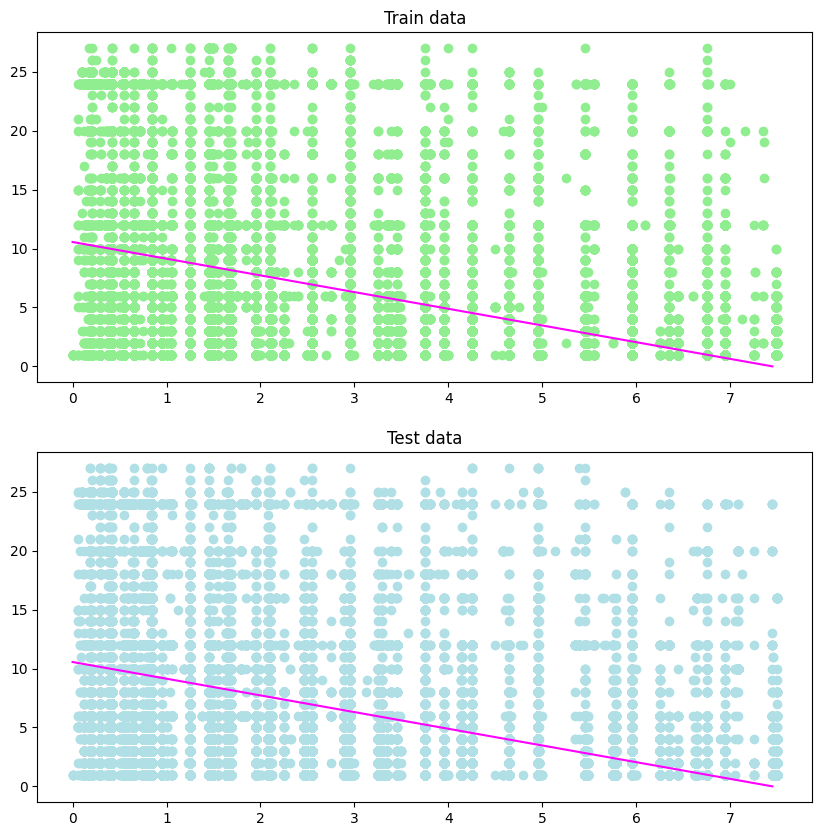

In [ ]:
fig, ax = plt.subplots(2, figsize=(10, 10))
ax[0].scatter(X_train, y_train, color = 'lightgreen')
ax[0].set_title('Train data')
ax[0].plot([0, -b/k], [b, 0], color = 'magenta')
ax[1].scatter(X_test, y_test, color = 'powderblue')
ax[1].set_title('Test data')
ax[1].plot([0, -b/k], [b, 0], color = 'magenta')
fig.show()

Нашли с помощью метода наименьших квадратов линейную функцию $y = kx + b$, приближающую неизвестную зависимость. У прямой отрицательный наклон, так как ближе к нижнему левому углу плотность расположения точек выше, чем в другой части графика. Из этого делаем вывод, что данная функция от цены товаров может использоваться для прогноза количества их продаж\
Теперь попробуем приблизить, используя не линейную функцию, а гиперболическую

In [ ]:
import numpy.linalg as lg
from numpy.linalg import inv


deg_x = np.vstack([0.4 + 2 * ((X_train-0.01) ** (-1))]).T
koeff_b = np.dot(np.dot(lg.inv(np.dot(deg_x.T, deg_x)), deg_x.T), y_train)
ans = "y = "
ans+=str(koeff_b[0])
ans+=" * x^(-1)"
print(ans, sep=' ')

y = 2.2808728368050266 * x^(-1)


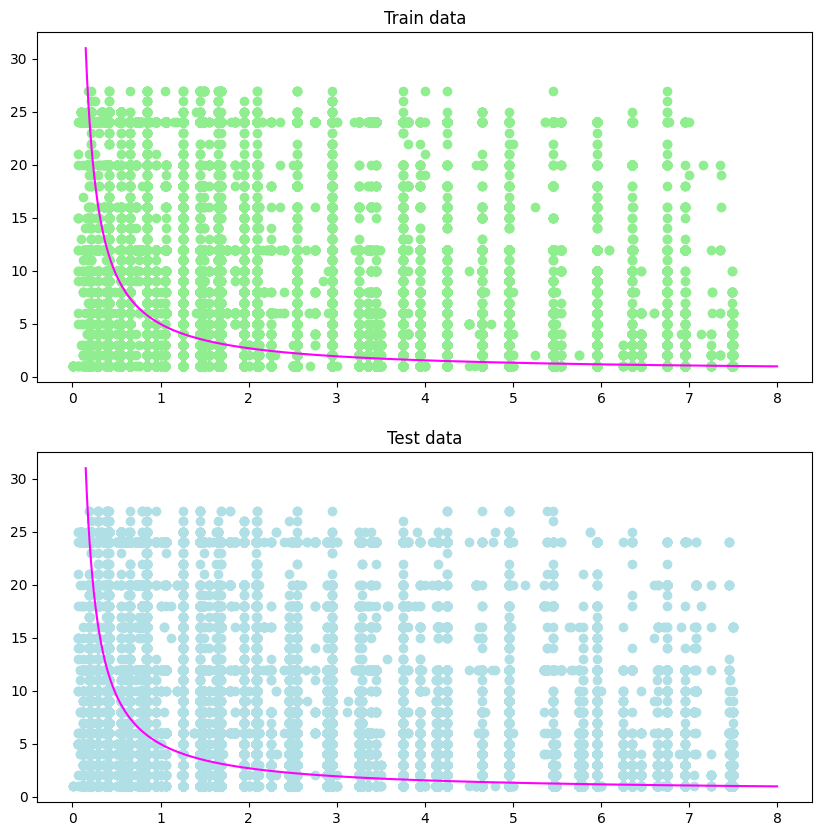

In [ ]:
rang = []
for j in range(150,8000):
  rang.append(j/1000)
y = [0.4 + 2/(i-0.001) * koeff_b for i in rang]
fig, ax = plt.subplots(2, figsize=(10, 10))
ax[0].scatter(X_train, y_train, color = 'lightgreen')
ax[0].set_title('Train data')
ax[0].plot([i for i in rang],  y, color = 'magenta')
ax[1].scatter(X_test, y_test, color = 'powderblue')
ax[1].set_title('Test data')
ax[1].plot([i for i in rang],  y, color = 'magenta')
fig.show()

Данная функция проходит ближе к началу координат, где наибольшее скопление точек, что является более точным приближением, чем линейная функция.

---
---


###**Модель 2**

Во второй модели осуществим классификацию покупателей с помощью RFM-анализа, где рассматриваются такие показатели как давность покупок (recency), их частота (frequency) и общая сумма покупок (monetary) \
\
Сначала расчитаем давность для каждого клиента для каждой выборки в зависимости от даты последней покупки. Следующим шагом будет подсчет частоты сделок, и, наконец, общие денежные затраты на покупку продукции. Отнормируем значения каждого признака

In [ ]:
recency_1 = data_1.groupby(by='Customer ID', as_index=False)['InvoiceDate'].max()
recency_2 = data_2.groupby(by='Customer ID', as_index=False)['InvoiceDate'].max()

last_purchase_data1 = recency_1['InvoiceDate'].max() #day of last purchase according to data_1
last_purchase_data2 = recency_1['InvoiceDate'].max() #day of last purchase according to data_2

recency_1['Recency'] = recency_1['InvoiceDate'].apply(lambda x: (last_purchase_data1 - x).days)
recency_2['Recency'] = recency_2['InvoiceDate'].apply(lambda x: (last_purchase_data2 - x).days)

recency_1['rec_rank'] = recency_1['Recency'].rank(ascending=False) # count numerical rank
recency_2['rec_rank'] = recency_2['Recency'].rank(ascending=False)

recency_1['rec_rank_norm'] = (recency_1['rec_rank']/recency_1['rec_rank'].max())*100 # normalize values
recency_2['rec_rank_norm'] = (recency_2['rec_rank']/recency_2['rec_rank'].max())*100

recency_1 = recency_1.drop(columns={'InvoiceDate', 'Recency', 'rec_rank'}) #leave only the customer's ID and the normalized value of recency
recency_2 = recency_2.drop(columns={'InvoiceDate', 'Recency', 'rec_rank'})




frequency_1 = data_1.groupby(by=['Customer ID'], as_index=False)['InvoiceDate'].count()
frequency_2 = data_2.groupby(by=['Customer ID'], as_index=False)['InvoiceDate'].count()

frequency_1 = frequency_1.rename(columns = {'InvoiceDate': 'Frequency'})
frequency_2 = frequency_2.rename(columns = {'InvoiceDate': 'Frequency'})

frequency_1['freq_rank'] = frequency_1['Frequency'].rank(ascending=True) # count numeracal rank
frequency_2['freq_rank'] = frequency_2['Frequency'].rank(ascending=True)

frequency_1['freq_rank_norm'] = (frequency_1['freq_rank']/frequency_1['freq_rank'].max())*100 # normalize values
frequency_2['freq_rank_norm'] = (frequency_2['freq_rank']/frequency_2['freq_rank'].max())*100

frequency_1 = frequency_1.drop(columns={'Frequency', 'freq_rank'}) #leave only the customer's ID and the normalized value of frequency
frequency_2 = frequency_2.drop(columns={'Frequency', 'freq_rank'})



data_1['Monetary'] = data_1['Price']*data_1['Quantity']
data_2['Monetary'] = data_2['Price']*data_2['Quantity']

monetary_1 = data_1.groupby(by='Customer ID', as_index=False)['Monetary'].sum()
monetary_2 = data_2.groupby(by='Customer ID', as_index=False)['Monetary'].sum()

monetary_1['mon_rank'] = monetary_1['Monetary'].rank(ascending=True) # count numeracal rank
monetary_2['mon_rank'] = monetary_2['Monetary'].rank(ascending=True)

monetary_1['mon_rank_norm'] = (monetary_1['mon_rank']/monetary_1['mon_rank'].max())*100 # normalize values
monetary_2['mon_rank_norm'] = (monetary_2['mon_rank']/monetary_2['mon_rank'].max())*100

monetary_1 = monetary_1.drop(columns={'Monetary', 'mon_rank'}) #leave only the customer's ID and the normalized value of monetary
monetary_2 = monetary_2.drop(columns={'Monetary', 'mon_rank'})



Теперь объединим все посчитанные значения в одну таблицу и посчитаем общее значение RFM для какждого покупателя по формуле

In [ ]:
rfm_1 = (recency_1.merge(frequency_1, on='Customer ID')).merge(monetary_1, on='Customer ID')
rfm_1['RFM'] = 0.1*rfm_1['rec_rank_norm']+0.3 * rfm_1['freq_rank_norm']+0.6*rfm_1['mon_rank_norm']

rfm_2 = (recency_2.merge(frequency_2, on='Customer ID')).merge(monetary_2, on='Customer ID')
rfm_2['RFM'] = 0.1*rfm_2['rec_rank_norm']+0.3 * rfm_2['freq_rank_norm']+0.6*rfm_2['mon_rank_norm']

display(rfm_1)
display(rfm_2)

,Customer ID,rec_rank_norm,freq_rank_norm,mon_rank_norm,RFM
0,12346.0,21.617665,44.879227,41.473430,40.509593
1,12347.0,96.181530,67.536232,75.483092,75.168878
2,12348.0,38.026107,30.555556,25.289855,28.143190
3,12349.0,56.569477,72.089372,82.608696,76.848977
4,12351.0,85.580090,30.555556,32.850242,37.434821
...,...,...,...,...,...
4135,18283.0,76.345004,91.135266,50.603865,65.337399
4136,18284.0,41.612785,30.555556,32.705314,32.951134
4137,18285.0,5.794803,9.842995,7.173913,7.836727
4138,18286.0,29.035013,63.285024,71.425121,64.744081


,Customer ID,rec_rank_norm,freq_rank_norm,mon_rank_norm,RFM
0,12347.0,96.240872,88.988308,94.178000,92.827380
1,12348.0,11.648510,9.377237,8.064901,8.816963
2,12349.0,74.440321,64.089716,71.772847,69.734655
3,12350.0,5.171795,27.284658,35.600095,30.062634
4,12352.0,57.955226,68.014794,75.065617,71.239331
...,...,...,...,...,...
4186,18280.0,8.152759,13.159151,15.628728,14.140258
4187,18281.0,19.897043,7.361012,2.791696,5.873026
4188,18282.0,88.950078,13.159151,11.787163,19.915051
4189,18283.0,94.169759,99.379623,86.900501,91.371163


In [ ]:
rfm_1['RFM'] = rfm_1['RFM'] * 0.05
rfm_1['RFM'] = rfm_1['RFM'].round(2)
rfm_1 = rfm_1[['Customer ID', 'RFM']]

rfm_2['RFM'] = rfm_2['RFM'] * 0.05
rfm_2['RFM'] = rfm_2['RFM'].round(2)
rfm_2 = rfm_2[['Customer ID', 'RFM']]

Теперь разделим покупателей по следубщим категориям:
 1. RFM < 1.6: Lost Customer
 2. 1.6 $\leqslant$ RFM < 3: Low-value customer
 3. 3 $\leqslant$ RFM < 4: Medium value customer
 4.  4 $\leqslant$ RFM < 4.5: High Value Customer
 5. 4.5 $\leqslant$ RFM: Top Customer

In [ ]:
rfm_1['Rank'] = rfm_1['RFM'].apply(lambda x: 1 if x<1.6 else 2 if 1.6<=x<3 else 3 if 3<=x<4
                                   else 4 if 4<=x<4.5 else 5)

rfm_2['Rank'] = rfm_2['RFM'].apply(lambda x: 1 if x<1.6 else 2 if 1.6<=x<3 else 3 if 3<=x<4
                                   else 4 if 4<=x<4.5 else 5)

<ipython-input-20-0594630cf1a8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_2['Rank'] = rfm_2['RFM'].apply(lambda x: 1 if x<1.6 else 2 if 1.6<=x<3 else 3 if 3<=x<4


Покажем на диаграмме количество покупателей каждой категории.

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


rfm_pie_1 = rfm_1.groupby('Rank').agg(num_customers=('Customer ID', 'count')).reset_index().sort_values(by='Rank')

rfm_pie_2 = rfm_2.groupby('Rank').agg(num_customers=('Customer ID', 'count')).reset_index().sort_values(by='Rank')

fig1 = px.pie(rfm_pie_1, names='Rank', values='num_customers')
fig2 = px.pie(rfm_pie_2, names='Rank', values='num_customers')
fig1.update_layout(title='Classification of customers in 2009-2010', legend=dict(title='Rank'))
fig2.update_layout(title='Classification of customers in 2010-2011', legend=dict(title='Rank'))
fig1.show()
fig2.show()

По диаграммам видно, что процент количества покупателей каждой группы практически не изменился. С учетом того, что размер выборок также отличается всего на 10 тысяч транзакций, можно заключить, что, вероятнее всего, в странах не было особенных экономических кризисов и иных потрясений.


------------------

---



###**Модель 3**

В данной модели на основании частоты покупок отдельных покупателей будем выявлять товары, которые регулярно покупали как в 2009-2010, так и в 2010-2011 годах. Это позволит предположить, какие товары и почему, вероятнее продолжат покупать и в последующие периоды времени, а какие - нет.

Критерием "регулярной" покупки будет служить максимальная разница по времени между двумя последовательными покупками - если эта разница превышает 60 дней, то покупка товара "нерегулярной".

Нас будет интересовать именно вид товара (без разницы какого он цвета, размера или с каким рисунком), поэтому сначала оставим для всех StockCode только первые пять цифр,  уникальные для каждого товара (изначально буквы в конце кода обозначают цвет, размер и другие признаки).

Пишем функцию для вычисления регулярности покупок, возвращает твблицу с колонками StockCode(код товара) и regularly(значение True - "частый" товар, False - иначе):

In [ ]:
def most_regular_products(data):
  model = data.loc[data.Country == 'United Kingdom'].reset_index()
  model['StockCode'] = model['StockCode'].astype(str)
  model['StockCode'] = model['StockCode'].apply(lambda x: x[:5])
  model = model[['Customer ID', 'StockCode', 'InvoiceDate']]
  model = model.sort_values(by=['Customer ID', 'StockCode', 'InvoiceDate']).reset_index(drop=True)

  model['transtitions_per_period'] = 0

  i = 0
  j = 0
  k = 0
  while i < len(model):
    while j < len(model) and model.loc[j,'Customer ID'] == model.loc[i, 'Customer ID']:
      max = 0
      flag_k = 0
      while k < len(model) and model.loc[k, 'StockCode'] == model.loc[j, 'StockCode']:
        if flag_k != 0:
          d = (pd.to_datetime(model.loc[k, 'InvoiceDate']) - pd.to_datetime(model.loc[k-1, 'InvoiceDate'])).days
          if d > max:
            max = d
        flag_k = 1
        model.loc[k, 'transtitions_per_period'] = max
        k+=1
      j = k
    i = j

  model = model.loc[model.transtitions_per_period != 0].reset_index(drop=True)
  model['reg'] = model['transtitions_per_period'] >= 60
  model = model[['StockCode', 'reg']].drop_duplicates().reset_index(drop=True)

  return model

Находим для для каждого товара в двух периодах(2009-2010 и 2010-2011 года) "регулярный" он или нет и составляем таблицу: StockCode - код товара, reg - "регулярный" ли в 2009-2010, reg\textunderscore2 - "нерегулярный" ли в 2010-2011:

In [ ]:
model1 = most_regular_products(data_1)
model2 = most_regular_products(data_2)

model2 = model2.rename(columns={'reg':'reg_2'})

result = pd.merge(model1, model2, how='left',on='StockCode')
result['stays_regular'] = result['reg'] * result['reg_2']

Теперь для каждого товара найдем количество людей, которые продолжили покупать его регулярно:

In [ ]:
reg_num = result.groupby('StockCode').agg(num_customers=('stays_regular', 'count')).reset_index()
reg_num = reg_num.sort_values(by=['num_customers'])
display(reg_num)

,StockCode,frequency_num
2301,TEST0,0
622,21552,0
623,21553,0
624,21554,0
2009,84678,0
...,...,...
1055,22185,4
1054,22181,4
1053,22179,4
1064,22198,4


Наибольшее значение num\textunderscore costomers - 4, поэтому рассмотримь товары, которые продолжили покупать 4 человека.

Посмотрим на товары, которые продолжили покупать регулярно, а какие нет:

In [ ]:
#товары, которые продолжили покупать часто

items = data_1[['StockCode', 'Description']]
items['StockCode'] = items['StockCode'].astype(str).apply(lambda x: x[:5])
items = items.drop_duplicates(subset=['StockCode']).reset_index(drop=True)

reg_num4 = reg_num.loc[reg_num.num_customers == 4]

for index, rows in reg_num4.iterrows():
  df = items.loc[items.StockCode == rows[0]].reset_index()
  if len(df) != 0:
    print(df.loc[0, 'Description'], '\n')

<ipython-input-29-f164df72b743>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



SET OF 6 RIBBONS VINTAGE CHRISTMAS 

SMALL PURPLE BABUSHKA NOTEBOOK  

ANGEL ON KNEES METAL POLE 100CM H 

HAND WARMER BABUSHKA DESIGN 

SMALL RED BABUSHKA NOTEBOOK  

HOT WATER BOTTLE I AM SO POORLY 

SMALL YELLOW BABUSHKA NOTEBOOK  

FELTCRAFT PRINCESS OLIVIA DOLL 

FELTCRAFT PRINCESS LOLA DOLL 

PINK 3 PIECE MINI DOTS CUTLERY SET 

POPPY'S PLAYHOUSE KITCHEN 

75 BLACK PETIT FOUR CASES 

POPPY'S PLAYHOUSE LIVINGROOM  

POPPY'S PLAYHOUSE BEDROOM  

MAKE YOUR OWN MONSOON CARD KIT 

MAKE YOUR OWN FLOWERPOWER CARD KIT 

MAKE YOUR OWN PLAYTIME CARD KIT 

LARGE YELLOW BABUSHKA NOTEBOOK  

ASSORTED COLOUR BIRD ORNAMENT 

RIBBON REEL, XMAS SOCK/BAUBLE 

RIBBON REEL SNOWY VILLAGE 

72 SWEETHEART FAIRY CAKE CASES 

6 CHOCOLATE LOVE HEART T-LIGHTS 

60 TEATIME FAIRY CAKE CASES 

SET 20 NAPKINS FAIRY CAKES DESIGN  

RIBBON REEL CHRISTMAS PRESENT  

RIBBON REEL, MAKING SNOWMEN  

SET/3 OCEAN SCENT CANDLE JEWEL BOX 

CANDLEHOLDER PINK HANGING HEART 

LARGE PURPLE BABUSHKA NOTEBOOK   

STRAWBERRY S

In [ ]:
#товары, которые перстали покупать часто

for index, rows in not_frequent_products.iterrows():
  df = items.loc[items.StockCode == rows[0]].reset_index()
  if len(df) != 0:
    print(df.loc[0, 'Description'], '\n')

STRAWBERRY FAIRY CAKE TEAPOT 

60 TEATIME FAIRY CAKE CASES 

JUMBO BAG TOYS  

PAINTED METAL PEARS ASSORTED 

HOME BUILDING BLOCK WORD 

KEY FOB , FRONT  DOOR  

JUMBO BAG PINK WITH WHITE SPOTS 

JUMBO SHOPPER VINTAGE RED PAISLEY 

ENAMEL FLOWER JUG CREAM 

HEART OF WICKER LARGE 

SET OF 3 BLACK FLYING DUCKS 

DOOR MAT UNION FLAG 

DOOR MAT BLACK FLOCK  

HANGING JAM JAR T-LIGHT HOLDER 

COLOUR GLASS. STAR T-LIGHT HOLDER 

WOODEN PICTURE FRAME WHITE FINISH 

WOOD BLACK BOARD ANT WHITE FINISH 

WOODEN FRAME ANTIQUE WHITE  

ASSORTED COLOUR BIRD ORNAMENT 

PEARL CRYSTAL PUMPKIN T-LIGHT HLDR 

CREAM SWEETHEART LETTER RACK 

JUMBO BAG RED WHITE SPOTTY  

WHITE HANGING HEART T-LIGHT HOLDER 

PINK JUICY FRUIT PHOTO FRAME 

ASSORTED COLOURS SILK FAN 

SANDALWOOD FAN 

WRAP ENGLISH ROSE  

WRAP BLUE RUSSIAN FOLKART 

SLEEPING CAT ERASERS 

FLOWER FAIRY,5 SUMMER B'DRAW LINERS 

WHITE TALL PORCELAIN T-LIGHT HOLDER 

PORCELAIN BUTTERFLY OIL BURNER 

QUEEN OF SKIES LUGGAGE TAG 

TROPICAL LUGGAGE T

<br/>

<br/>

Из каждой группы найдем по 5 товаров и выдвинем предположение в связи с чем такое могло случиться.

Товары, которые продолжили регулярно покупать:
1. SMALL NOTEBOOK - тетради постоянно заканчиваются
2. POPPY'S PLAYHOUSE - это популярная детская игрушка, которая состоит из разных частей, которые можно много раз докупать
3. PENCILS SMALL TUBE SKULL - ручки постоянно и используют, из-за чего они заканчиваются
4.  200 BENDY SKULL STRAWS - одноразовые трубочки для напитков
5.  PLASTERS - пластыри, так же как и трубочки, вещь одноразовая

<br/>

Товары, которые перестали регулярно покупать:
1. PARTY PIZZA DISH PINK+WHITE SPOT - посуда для вечеринки. Покупатели могли переехать, пока некого звать на вечеринки, а до этого были друзья на старом месте.
2. BLUE CHENILLE SHAGGY CUSHION COVER - наволочки на диванные подушки а они обычно быстро не изнашиваются
3. PINK SQUARE COMPACT MIRROR - обычно людям много маленьких зеркал не нужно
4. BLACK TEA,COFFEE,SUGAR JARS - постепенно купили банки для всего, что нужно, а потом их нет смысла часто менять из-за их относительной долговечности
5. DOGGY RUBBER - собака могла умереть, поэтому и игрушки не нужны.